<a href="https://colab.research.google.com/github/aryanksingh0/Telecom-Churn-Analysis/blob/main/Churn_model_building_f.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Without Smote

## Importing and splitting

In [ ]:
!pip install shap


In [ ]:
#!/bin/bash
! kaggle datasets download blastchar/telco-customer-churn

Dataset URL: https://www.kaggle.com/datasets/blastchar/telco-customer-churn
License(s): copyright-authors
telco-customer-churn.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# Importing necessary libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import recall_score, classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Setting up visualizations
sns.set_style("whitegrid")
sns.set_palette("Set2")

In [ ]:
df = pd.read_csv('/content/telco-customer-churn.zip')
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'],errors = 'coerce')
df.drop(columns = 'customerID',inplace = True)

X = df.drop('Churn', axis=1).copy()
y = df['Churn'].copy()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify numerical and categorical columns in X_train
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns

# Define the numerical pipeline
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Define the categorical pipeline
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine the two pipelines using ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])


In [ ]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

## Model Building

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(class_weight='balanced')
model.fit(X_train_transformed, y_train)
y_pred = model.predict(X_test_transformed)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")


Accuracy: 0.7381121362668559
Classification Report:
              precision    recall  f1-score   support

          No       0.90      0.72      0.80      1035
         Yes       0.50      0.78      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409



#### Cross Validation

In [ ]:
cv = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(model, X_train_transformed, y_train, cv=cv, scoring='accuracy')
print(f"Cross-validation accuracy scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean()}")

Cross-validation accuracy scores: [0.77817214 0.76397516 0.76308784 0.73735581 0.71847247]
Mean CV accuracy: 0.7522126836679532


## Hyperparameter tunning

In [ ]:
# Hyperparameter tuning using Grid Search
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_transformed, y_train)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

Best parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation score: 0.7523896731447232


## Final Model

In [ ]:
final_model = LogisticRegression(**grid_search.best_params_,class_weight='balanced')  # Use the best parameters
final_model.fit(X_train_transformed, y_train)

LogisticRegression(C=0.1, class_weight='balanced', solver='liblinear')

In [ ]:
y_pred_final = final_model.predict(X_test_transformed)
accuracy = accuracy_score(y_test, y_pred_final)
print("Final test accuracy:", accuracy)

Final test accuracy: 0.7416607523066004


In [ ]:
print(f"Accuracy: {accuracy_score(y_test, y_pred_final)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_final)}")


Accuracy: 0.7416607523066004
Classification Report:
              precision    recall  f1-score   support

          No       0.90      0.73      0.80      1035
         Yes       0.51      0.79      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.76      1409



#### Cross Validation for final model

In [ ]:
cv = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(final_model, X_train_transformed, y_train, cv=cv, scoring='accuracy')
print(f"Cross-validation accuracy scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean()}")

Cross-validation accuracy scores: [0.77817214 0.76397516 0.76574978 0.73824312 0.71580817]
Mean CV accuracy: 0.7523896731447232


## Testing

In [ ]:
model = LogisticRegression()

model.fit(X_test_transformed, y_test)

y_pred = model.predict(X_test_transformed)

cv = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(model, X_test_transformed, y_test, cv=cv, scoring='accuracy')
print(f"Cross-validation accuracy scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean()}")

Cross-validation accuracy scores: [0.77659574 0.76595745 0.79432624 0.79078014 0.81850534]
Mean CV accuracy: 0.7892329825092753


In [ ]:
cv = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(final_model, X_test_transformed, y_test, cv=cv, scoring='accuracy')
print(f"Cross-validation accuracy scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean()}")

Cross-validation accuracy scores: [0.71276596 0.73404255 0.76595745 0.70921986 0.78291815]
Mean CV accuracy: 0.7409807930138058


# 2. With Smote

## Importing and spliting

In [ ]:
df = pd.read_csv('/content/telco-customer-churn.zip')
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'],errors = 'coerce')
df.drop(columns = 'customerID',inplace = True)

X = df.drop('Churn', axis=1).copy()
y = df['Churn'].copy()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify numerical and categorical columns in X_train
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns

# Define the numerical pipeline
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Define the categorical pipeline
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine the two pipelines using ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])


In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Apply SMOTE to the transformed training data
rs_X_train, rs_y_train= smote.fit_resample(X_train_transformed, y_train)



## Model Building

In [ ]:
model = LogisticRegression()
model.fit(rs_X_train, rs_y_train)
y_pred = model.predict(X_test_transformed)

In [ ]:
# Evaluate the model on the test data
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")


Accuracy: 0.7409510290986515
Classification Report:
              precision    recall  f1-score   support

          No       0.90      0.73      0.80      1035
         Yes       0.51      0.78      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409



#### Cross Validation

In [ ]:
cv = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(model, rs_X_train, rs_y_train, cv=cv, scoring='accuracy')
print(f"Cross-validation accuracy scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean()}")

Cross-validation accuracy scores: [0.78804348 0.77173913 0.77415459 0.78247734 0.77099698]
Mean CV accuracy: 0.7774823036618649


## Hyperparameter tunning

In [ ]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'class_weight': ['balanced']
}
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(rs_X_train, rs_y_train)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

Best parameters: {'C': 100, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'}
Best cross-validation score: 0.7780865332691157


## Final Model

In [ ]:
final_model = LogisticRegression(**grid_search.best_params_)
final_model.fit(rs_X_train, rs_y_train)

LogisticRegression(C=100, class_weight='balanced', penalty='l1', solver='saga')

In [ ]:
y_pred_final = final_model.predict(X_test_transformed)
accuracy = accuracy_score(y_test, y_pred_final)
print("Final test accuracy:", accuracy)

Final test accuracy: 0.7395315826827538


In [ ]:
print(f"Accuracy: {accuracy_score(y_test, y_pred_final)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_final)}")


Accuracy: 0.7395315826827538
Classification Report:
              precision    recall  f1-score   support

          No       0.90      0.72      0.80      1035
         Yes       0.51      0.78      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409



#### Cross Validation for final model

In [ ]:
cv = StratifiedKFold(n_splits=5)
cv_scores = cross_val_score(final_model, X_test_transformed, y_test, cv=cv, scoring='accuracy')
print(f"Cross-validation accuracy scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean()}")

Cross-validation accuracy scores: [0.70921986 0.71985816 0.76241135 0.69148936 0.77224199]
Mean CV accuracy: 0.7310441432573634


# Interpret Coefficients:

In [ ]:
feature_names = preprocessor.get_feature_names_out()
coefficients = final_model.coef_[0]
feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort by the absolute value of the coefficients
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)

# Display the most important features
print(feature_importance.head(10))

                                  Feature  Coefficient  Abs_Coefficient
2                     num__MonthlyCharges    -1.962949         1.962949
1                             num__tenure    -1.573863         1.573863
16       cat__InternetService_Fiber optic     1.325750         1.325750
15               cat__InternetService_DSL    -1.082816         1.082816
3                       num__TotalCharges     0.929811         0.929811
38                 cat__Contract_Two year    -0.870594         0.870594
36           cat__Contract_Month-to-month     0.661563         0.661563
35               cat__StreamingMovies_Yes     0.574089         0.574089
32                   cat__StreamingTV_Yes     0.566831         0.566831
22  cat__OnlineBackup_No internet service    -0.537215         0.537215


In [ ]:
import shap
explainer = shap.Explainer(final_model, X_train_transformed)
shap_values = explainer(X_test_transformed)

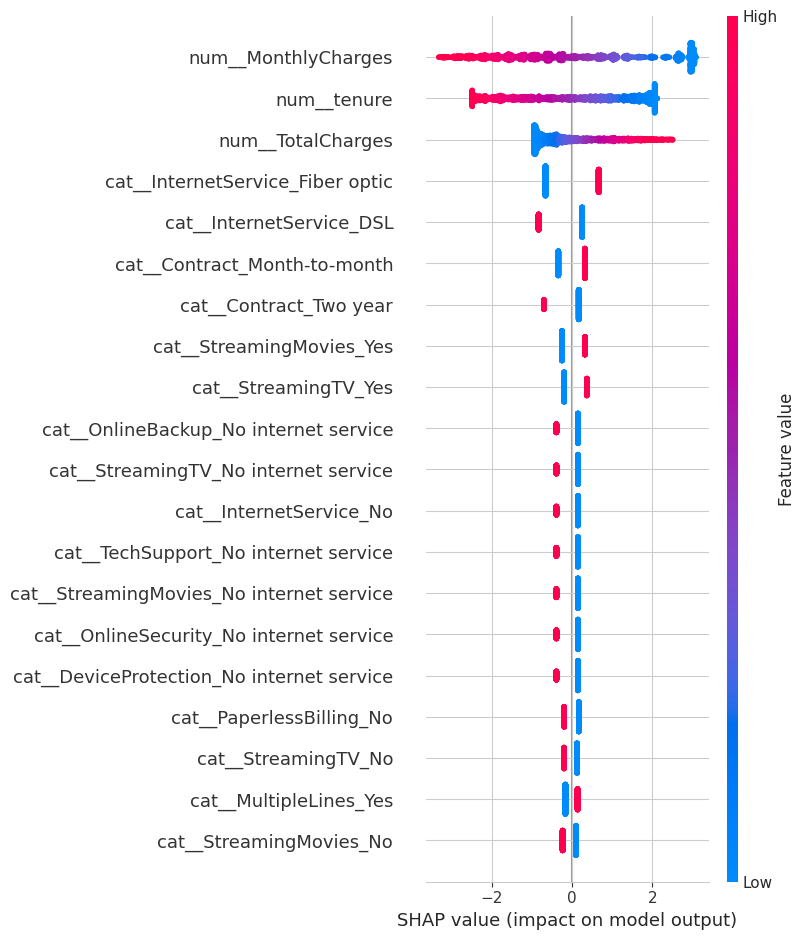

In [ ]:
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names)